In [1]:
import torch
import torch.linalg as tla
import torch.autograd
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import common

In [2]:
N = 7
A_np = np.eye(N) * 2 - np.eye(N, k=-1) - np.eye(N, k=1)
A = torch.Tensor(A_np)
A.requires_grad = True

In [3]:
b_np = np.zeros(N)
b_np[N//2] = 1.
b = torch.Tensor(b_np)
b.requires_grad = True
b

tensor([0., 0., 0., 1., 0., 0., 0.], requires_grad=True)

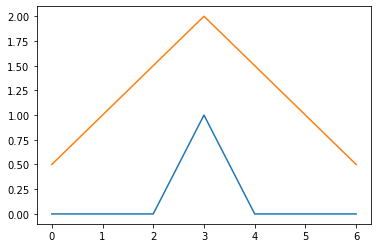

In [4]:
plt.plot(b_np)
plt.plot(la.solve(A_np, b_np))

In [5]:
def scale_row(N, i, alpha):
    d = torch.ones(N)
    d[i] = alpha
    return torch.diag(d)

In [6]:
def row_op(N, i, j, alpha):
    Z = torch.eye(N)
    Z[i,j] = alpha
    return Z

In [7]:
# elementary vector
def e(N, i):
    z = torch.zeros(N)
    z[i] = 1.
    return z

In [8]:
def lu_factor(A):
    N = A.shape[0]
    
    U = A
    L = torch.eye(N)
    
    for j in range(N-1):
        for i in range(j+1, N):
            if U[i,j] == 0:
                continue

            R = row_op(N, i, j, -U[i,j] / U[j,j])
            Rinv = row_op(N, i, j, U[i, j]/U[j,j])
            U = R@U
            L = L@Rinv
    return L, U

In [9]:
L1, U1 = lu_factor(A)

In [10]:
#LU = A
torch.all(torch.isclose(L1@U1, A))

tensor(True)

In [11]:
def lower_tri_solve(L, b, unit_diag=True):
    x = b
    n = len(b)
    for i in range(n):
        for j in range(0, i):
            if L[i,j] != 0:
                x = x - e(n, i) * L[i, j] * x[j]
        if not unit_diag:
            x = scale_row(n, i, 1/L[i, i]) @ x
    return x

def upper_tri_solve(U, b, unit_diag=False):
    x = b
    n = len(b)
    for i in range(n-1, -1, -1):
        for j in range(i+1, n):
            if U[i,j] != 0:
                x = x - e(n, i) * U[i,j] * x[j]
        if not unit_diag:
            x = scale_row(n, i, 1/U[i, i]) @ x
    return x

def lu_solve(L, U, b):
    return upper_tri_solve(U, lower_tri_solve(L, b))

In [12]:
x1 = lu_solve(L1, U1, b)
x1

tensor([0.5000, 1.0000, 1.5000, 2.0000, 1.5000, 1.0000, 0.5000],
       grad_fn=<MvBackward0>)

In [13]:
L2, U2 = common.lu_factor(A)
print(torch.all(torch.isclose(L2@U2, A)))
x2 = common.lu_solve(L2, U2, b)
print(x2)

tensor(True)
tensor([0.5000, 1.0000, 1.5000, 2.0000, 1.5000, 1.0000, 0.5000],
       grad_fn=<ScaleVecPrimitiveBackward>)


In [14]:
torch.round(torch.autograd.grad(x1.sum(), A, retain_graph=True)[0])

tensor([[ -2.,  -4.,  -4.,  -5.,  -3.,  -1.,  -0.],
        [ -3.,  -6.,  -9., -10.,  -6.,  -3.,  -1.],
        [  0.,  -8., -11., -15.,  -9.,  -4.,  -1.],
        [  0.,   0., -12., -16., -12.,  -6.,  -2.],
        [  0.,   0.,   0., -15., -11.,  -7.,  -2.],
        [  0.,   0.,   0.,   0.,  -9.,  -6.,  -3.],
        [  0.,   0.,   0.,   0.,   0.,  -3.,  -2.]])

In [15]:
torch.round(torch.autograd.grad(x2.sum(), A, retain_graph=True)[0])

tensor([[ -2.,  -4.,  -4.,  -5.,  -3.,  -1.,  -0.],
        [ -3.,  -6.,  -9., -10.,  -6.,  -3.,  -1.],
        [  0.,  -8., -11., -15.,  -9.,  -4.,  -1.],
        [  0.,   0., -12., -16., -12.,  -6.,  -2.],
        [  0.,   0.,   0., -15., -11.,  -7.,  -2.],
        [  0.,   0.,   0.,   0.,  -9.,  -6.,  -3.],
        [  0.,   0.,   0.,   0.,   0.,  -3.,  -2.]])

In [16]:
torch.round(torch.autograd.grad(tla.solve(A, b).sum(), A, retain_graph=True)[0])

tensor([[ -2.,  -4.,  -5.,  -7.,  -5.,  -3.,  -2.],
        [ -3.,  -6.,  -9., -12.,  -9.,  -6.,  -3.],
        [ -4.,  -8., -11., -15., -11.,  -7.,  -4.],
        [ -4.,  -8., -12., -16., -12.,  -8.,  -4.],
        [ -4.,  -8., -11., -15., -11.,  -7.,  -4.],
        [ -3.,  -6.,  -9., -12.,  -9.,  -6.,  -3.],
        [ -2.,  -4.,  -5.,  -7.,  -5.,  -3.,  -2.]])

In [17]:
torch.round(common.c_fd(lambda A: tla.solve(A, b).sum(), A))

tensor([[ -2.,  -4.,  -5.,  -7.,  -5.,  -3.,  -2.],
        [ -3.,  -6.,  -9., -12.,  -9.,  -6.,  -3.],
        [ -4.,  -8., -11., -15., -11.,  -7.,  -4.],
        [ -4.,  -8., -12., -16., -12.,  -8.,  -4.],
        [ -4.,  -7., -11., -15., -11.,  -7.,  -4.],
        [ -3.,  -6.,  -9., -12.,  -9.,  -6.,  -3.],
        [ -2.,  -4.,  -5.,  -7.,  -5.,  -4.,  -2.]], grad_fn=<RoundBackward0>)

In [18]:
torch.round(torch.autograd.grad(x1.sum(), b, retain_graph=True)[0])

tensor([4., 6., 8., 8., 7., 6., 3.])

In [19]:
torch.round(torch.autograd.grad(x2.sum(), b, retain_graph=True)[0])

tensor([4., 6., 8., 8., 7., 6., 3.])

In [20]:
torch.round(torch.autograd.grad(tla.solve(A, b).sum(), b, retain_graph=True)[0])

tensor([4., 6., 7., 8., 7., 6., 3.])

In [21]:
torch.round(common.c_fd(lambda b: tla.solve(A.detach(), b.flatten()).sum(), b.detach()).flatten())

tensor([3., 6., 7., 8., 7., 6., 3.])